In [1]:
import sys
sys.path.append("../../")  # 根据你的 notebook 路径设置

from sl_inference_restart.mock_generator.mock_generator import run_mock_simulation


In [46]:
df_lens, mock_lens_data, mock_observed_data = run_mock_simulation(100, if_source=True)

Processing lenses: 100%|██████████| 100/100 [00:00<00:00, 290.55it/s]


In [3]:
mock_lens_data.columns

Index(['xA', 'xB', 'beta', 'kappaA', 'kappaB', 'gammaA', 'gammaB',
       'magnificationA', 'magnificationB', 'kappa_starA', 'kappa_starB',
       'alphaA', 'alphaB', 'sA', 'sB', 'einstein_radius_kpc',
       'einstein_radius_arcsec', 'scatter_mag', 'is_lensed',
       'magnitude_observedA', 'magnitude_observedB', 'mag_source',
       'maximum_magnitude', 'beta_unit', 'logalpha_sps', 'logM_star',
       'logM_star_sps', 'logM_star_sps_observed', 'logM_halo', 'logRe', 'zl',
       'zs'],
      dtype='object')

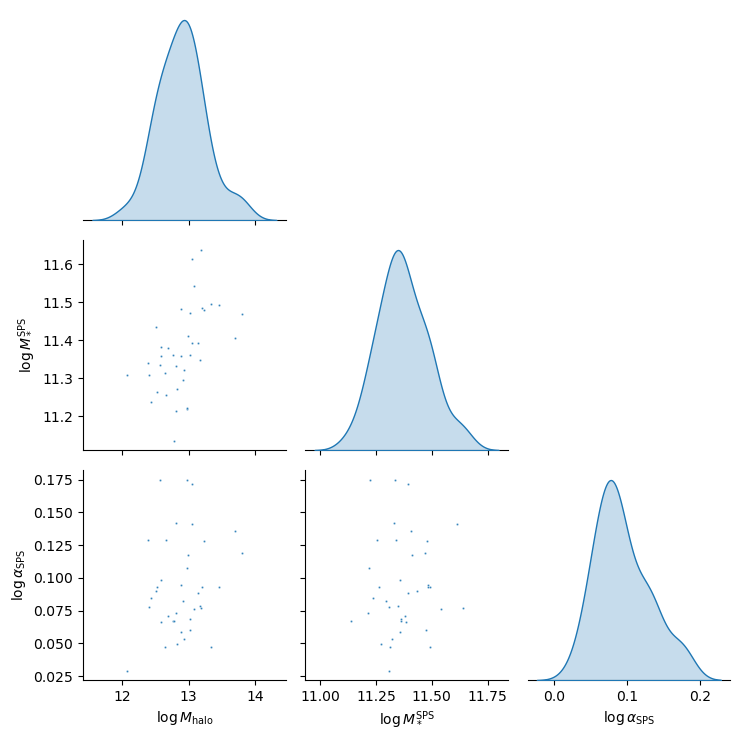

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# === 读取 mock lens 数据 ===
mock_lens_data = pd.read_csv("../../mock_lens_data.csv")

# === 提取感兴趣的列 ===
mock_data = mock_lens_data[["logM_halo", "logM_star_sps", "logalpha_sps"]]

# === 可选：设定标签（LaTeX 风格）===
mock_data.columns = [
    r"$\log M_{\rm halo}$",
    r"$\log M_*^{\rm SPS}$",
    r"$\log \alpha_{\rm SPS}$"
]

# === 绘图 ===
sns.pairplot(
    mock_data,
    diag_kind="kde",
    markers=".",
    plot_kws={"alpha": 0.9, "s": 10},
    corner=True  # 去掉右上角镜像图
)

plt.tight_layout()
plt.show()


In [22]:
from sl_inference_restart.mock_generator.mass_sampler import generate_samples

In [28]:
samples = generate_samples(
    model="deVauc",
    n_samples=10000,)

In [29]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# === 生成模拟数据 ===


logM_star_sps_observed = samples['logM_star_sps']
logMhalo_sps_observed = samples['logMh']

# ========== Step 1: 拟合 logMh 模型 (假设 xi = 0) ==========
x = logM_star_sps_observed - 11.4
y = logMhalo_sps_observed

reg_Mh = LinearRegression().fit(x.reshape(-1, 1), y)

mu_DM = reg_Mh.intercept_
beta_DM = reg_Mh.coef_[0]

residuals = y - reg_Mh.predict(x.reshape(-1, 1))
sigma_DM = np.std(residuals)

# ========== 输出结果 ==========
print(f"mu_DM    = {mu_DM:.4f}")
print(f"beta_DM  = {beta_DM:.4f}")
print(f"sigma_DM = {sigma_DM:.4f}")

# ========== 可选：保存结果 ==========
fit_result = {
    "mu_DM": mu_DM,
    "beta_DM": beta_DM,
    "sigma_DM": sigma_DM
}


mu_DM    = 12.9123
beta_DM  = 2.0120
sigma_DM = 0.3695


In [41]:
df_lens, mock_lens_data, mock_observed_data = run_mock_simulation(10000, if_source=True)

samples = generate_samples(
    model="deVauc",
    n_samples=10000,)

Processing lenses: 100%|██████████| 10000/10000 [00:33<00:00, 294.50it/s]


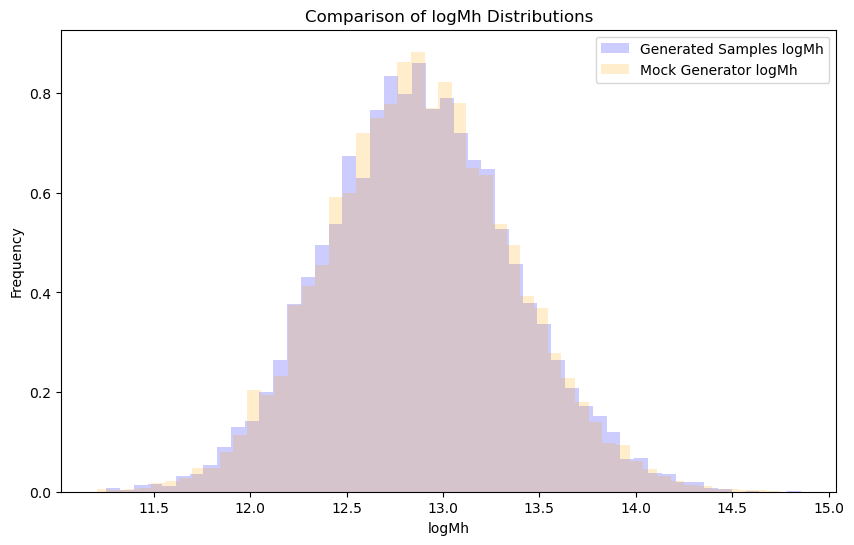

In [43]:
# 对比generated samples和mock generator 的logMh，logMstarsps
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(samples['logMh'], bins=50, alpha=0.2, label='Generated Samples logMh', color='blue',density=True)
plt.hist(df_lens['logM_halo'], bins=50, alpha=0.2, label='Mock Generator logMh', color='orange',density=True)
plt.xlabel('logMh')
plt.ylabel('Frequency')
plt.title('Comparison of logMh Distributions')
plt.legend()

In [47]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# === 生成模拟数据 ===
# mock_lens_data, mock_observed_data = run_mock_simulation(10000, 
logM_star_sps_observed = df_lens['logM_star_sps'].values
logMhalo_sps_observed = df_lens['logM_halo'].values

# ========== Step 1: 拟合 logMh 模型 (假设 xi = 0) ==========
x = logM_star_sps_observed - 11.4
y = logMhalo_sps_observed

reg_Mh = LinearRegression().fit(x.reshape(-1, 1), y)

mu_DM = reg_Mh.intercept_
beta_DM = reg_Mh.coef_[0]

residuals = y - reg_Mh.predict(x.reshape(-1, 1))
sigma_DM = np.std(residuals)

# ========== 输出结果 ==========
print(f"mu_DM    = {mu_DM:.4f}")
print(f"beta_DM  = {beta_DM:.4f}")
print(f"sigma_DM = {sigma_DM:.4f}")

# ========== 可选：保存结果 ==========
fit_result = {
    "mu_DM": mu_DM,
    "beta_DM": beta_DM,
    "sigma_DM": sigma_DM
}


mu_DM    = 12.8677
beta_DM  = 2.2368
sigma_DM = 0.3731


In [21]:
from scipy.optimize import minimize
from scipy.stats import norm

x = logM_star_sps_observed
y = logMhalo_sps_observed

def neg_loglike(theta):
    mu_h0, beta_h, log_sigma = theta
    sigma = np.exp(log_sigma)
    mu = mu_h0 + beta_h * (x - 11.4)
    return -np.sum(norm.logpdf(y, loc=mu, scale=sigma))

theta0 = [12.5, 1.5, np.log(0.3)]
result = minimize(neg_loglike, theta0)

mu_h0_fit, beta_h_fit, log_sigma_fit = result.x
sigma_fit = np.exp(log_sigma_fit)

print(f"[MLE Fit]")
print(f"mu_h0  = {mu_h0_fit:.4f}")
print(f"beta_h = {beta_h_fit:.4f}")
print(f"sigma  = {sigma_fit:.4f}")


[MLE Fit]
mu_h0  = 12.8910
beta_h = 1.4608
sigma  = 0.3220


In [ ]:
{'mu_star': 11.252, 'sigma_star': 0.202, 'log_s_star': 0.17, 'mu_R0': 0.774, 'beta_R': 0.977, 'sigma_R': 0.112, 'mu_h0': 12.91, 'beta_h': 2.04, 'xi_h': 0.0, 'sigma_h': 0.37}

In [20]:
from sl_inference_restart.mock_generator.mass_sampler import MODEL_PARAMS
print(MODEL_PARAMS["deVauc"]["mu_h0"], MODEL_PARAMS["deVauc"]["beta_h"], MODEL_PARAMS["deVauc"]["sigma_h"])

12.91 2.04 0.37


In [3]:
import pandas as pd
mock_lens_data = pd.df = pd.read_csv("../../mock_lens_data.csv")

Processing lenses: 100%|██████████| 10000/10000 [00:33<00:00, 298.63it/s]


In [13]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

mock_lens_data, mock_observed_data = run_mock_simulation(10000)
# 假设你已加载 mock_lens_data
logM_star_sps_observed = mock_lens_data['logM_star_sps'].values
logRe_observed = mock_lens_data['logRe'].values
logMhalo_sps_observed = mock_lens_data['logM_halo'].values


# ========== Step 1: 拟合 logRe_model ==========
x1 = logM_star_sps_observed - 11.4
y1 = logRe_observed
reg_Re = LinearRegression().fit(x1.reshape(-1, 1), y1)

a = reg_Re.intercept_
b = reg_Re.coef_[0]
logRe_model = a + b * x1

# ========== Step 2: 拟合 logMh 模型 ==========
X = np.vstack([
    logM_star_sps_observed - 11.4,
    logRe_observed - logRe_model
]).T
y = logMhalo_sps_observed

reg_Mh = LinearRegression().fit(X, y)
mu_DM = reg_Mh.intercept_
beta_DM, xi_DM = reg_Mh.coef_

residuals = y - reg_Mh.predict(X)
sigma_DM = np.std(residuals)

# ========== 输出结果 ==========
print(f"mu_DM    = {mu_DM:.4f}")
print(f"beta_DM  = {beta_DM:.4f}")
print(f"xi_DM    = {xi_DM:.4f}")
print(f"sigma_DM = {sigma_DM:.4f}")

# ========== 可选：保存结果 ==========
fit_result = {
    "mu_DM": mu_DM,
    "beta_DM": beta_DM,
    "xi_DM": xi_DM,
    "sigma_DM": sigma_DM,
    "a_logRe_model": a,
    "b_logRe_model": b
}


mu_DM    = 12.8875
beta_DM  = 1.4622
xi_DM    = -0.2686
sigma_DM = 0.3188


In [16]:
from sl_inference_restart.mock_generator.mass_sampler import MODEL_PARAMS
print(MODEL_PARAMS["deVauc"])

{'mu_star': 11.252, 'sigma_star': 0.202, 'log_s_star': 0.17, 'mu_R0': 0.774, 'beta_R': 0.977, 'sigma_R': 0.112, 'mu_h0': 12.91, 'beta_h': 2.04, 'xi_h': 0.0, 'sigma_h': 0.37}


In [18]:
a,b

(0.7899261717705088, 0.9278411771948047)

In [19]:
from sklearn.metrics import r2_score

y_true = logMhalo_sps_observed
y_pred = reg_Mh.predict(X)
r2 = r2_score(y_true, y_pred)
print(f"R^2 score = {r2:.4f}")


R^2 score = 0.2821


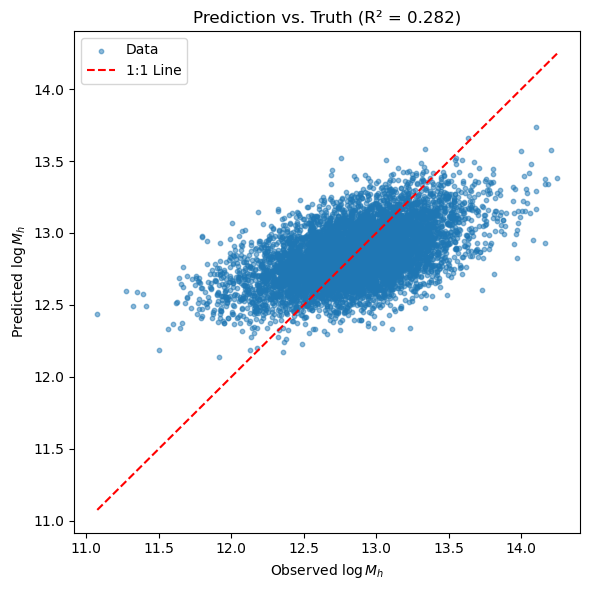

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.5, s=10, label='Data')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label='1:1 Line')
plt.xlabel('Observed $\\log M_h$')
plt.ylabel('Predicted $\\log M_h$')
plt.title(f'Prediction vs. Truth (R² = {r2:.3f})')
plt.legend()
plt.tight_layout()
plt.show()


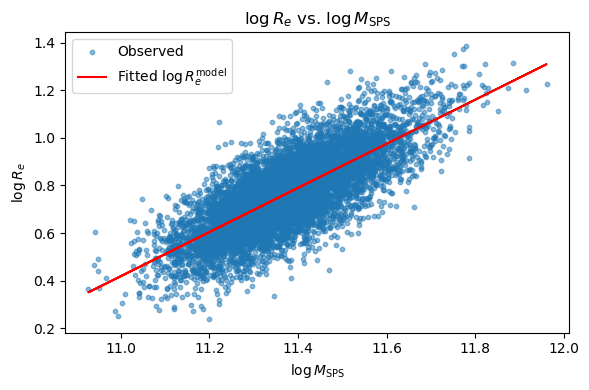

In [21]:
plt.figure(figsize=(6, 4))
plt.scatter(logM_star_sps_observed, logRe_observed, s=10, alpha=0.5, label='Observed')
plt.plot(logM_star_sps_observed, logRe_model, 'r-', label='Fitted $\\log R_e^{\\rm model}$')
plt.xlabel('$\\log M_{\\rm SPS}$')
plt.ylabel('$\\log R_e$')
plt.title('$\\log R_e$ vs. $\\log M_{\\rm SPS}$')
plt.legend()
plt.tight_layout()
plt.show()


In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

x = logM_star_sps_observed - 11.4
y = logMhalo_sps_observed

reg_simple = LinearRegression().fit(x.reshape(-1, 1), y)
r2_simple = r2_score(y, reg_simple.predict(x.reshape(-1, 1)))
print(f"R² (only logM_*) = {r2_simple:.4f}")


R² (only logM_*) = 0.2743


mu_DM    = 12.8855
beta_DM  = 1.4670
sigma_DM = 0.3232
R²       = 0.2743


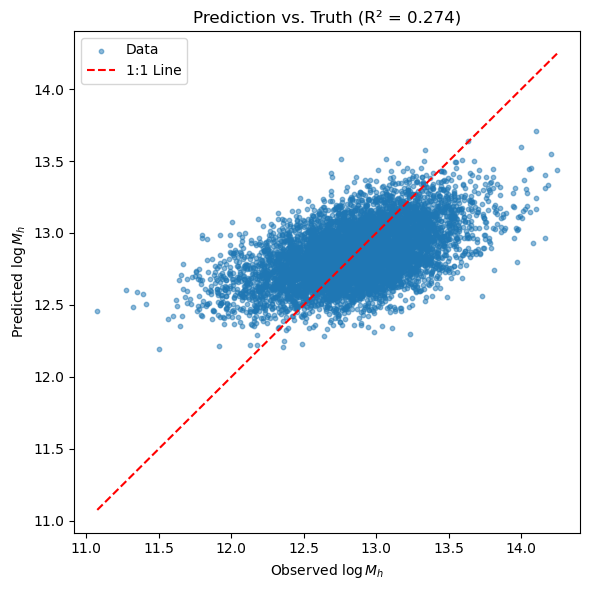

In [24]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

logM_star_sps_observed = mock_lens_data['logM_star_sps'].values
logRe_observed = mock_lens_data['logRe'].values
logMhalo_sps_observed = mock_lens_data['logM_halo'].values

# 构造输入特征 (logM_sps - 11.4)
X = (logM_star_sps_observed - 11.4).reshape(-1, 1)
y = logMhalo_sps_observed

# 拟合线性模型
reg = LinearRegression().fit(X, y)
mu_DM = reg.intercept_
beta_DM = reg.coef_[0]
y_pred = reg.predict(X)
sigma_DM = np.std(y - y_pred)
r2 = r2_score(y, y_pred)

# 打印结果
print(f"mu_DM    = {mu_DM:.4f}")
print(f"beta_DM  = {beta_DM:.4f}")
print(f"sigma_DM = {sigma_DM:.4f}")
print(f"R²       = {r2:.4f}")

# 可视化：预测 vs 真实
plt.figure(figsize=(6, 6))
plt.scatter(y, y_pred, alpha=0.5, s=10, label='Data')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='1:1 Line')
plt.xlabel('Observed $\\log M_h$')
plt.ylabel('Predicted $\\log M_h$')
plt.title(f'Prediction vs. Truth (R² = {r2:.3f})')
plt.legend()
plt.tight_layout()
plt.show()


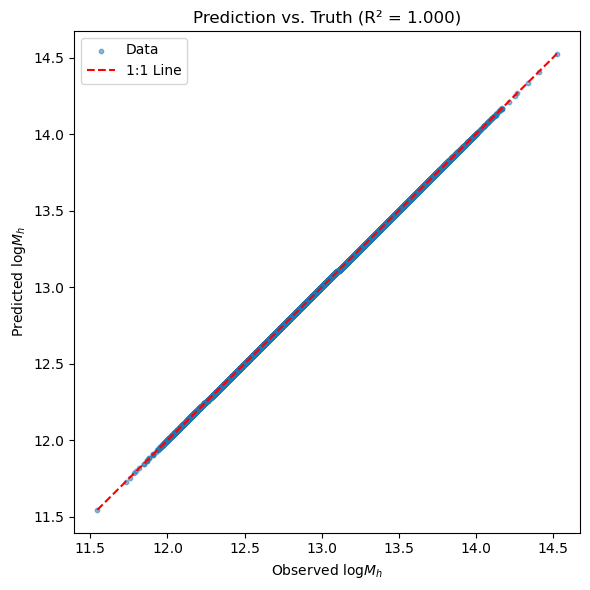

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mass_sampler import generate_samples, MODEL_PARAMS

# ====== 手动降低 logMh 的散度（噪声） ======
MODEL_PARAMS['deVauc']['sigma_h'] = 0.  # 原为 0.37，改为更小值以减小噪声

# ====== 生成模拟样本 ======
n_samples = 100000
data = generate_samples(n_samples, model='deVauc', random_state=42)

logM_star_sps = data['logM_star_sps']
logMh = data['logMh']


# model_name = 'deVauc'
# params = MODEL_PARAMS[model_name]
# samples = generate_samples(100000, model=model_name)

# logM_star_sps = samples['logM_star_sps']
# logRe = samples['logRe']
# logMh = samples['logMh']
# ====== 简单拟合并绘图 ======
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# X = logM_star_sps.reshape(-1, 1)
X = (logM_star_sps - 11.4).reshape(-1, 1)
y = logMh

model = LinearRegression().fit(X, y)
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)

# ====== 绘图展示结果 ======
plt.figure(figsize=(6, 6))
plt.scatter(y, y_pred, s=10, alpha=0.5, label="Data")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='1:1 Line')
plt.xlabel("Observed log$M_h$")
plt.ylabel("Predicted log$M_h$")
plt.title(f"Prediction vs. Truth (R² = {r2:.3f})")
plt.legend()
plt.tight_layout()
plt.show()


In [5]:
model_name = 'deVauc'
params = MODEL_PARAMS[model_name]
samples = generate_samples(100000, model=model_name)

logM_star_sps = samples['logM_star_sps']
logRe = samples['logRe']
logMh = samples['logMh']

mu_DM    = 12.9112
beta_DM  = 2.0388
sigma_DM = 0.3711
R²       = 0.4081


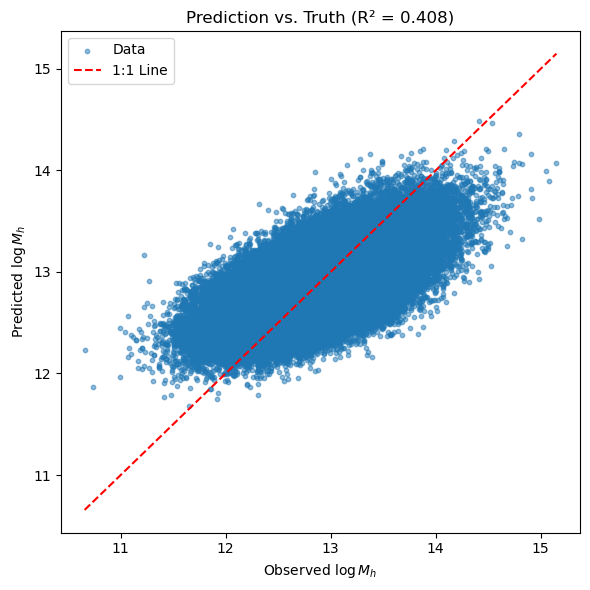

In [6]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

logM_star_sps_observed = logM_star_sps
logMhalo_sps_observed = logMh

# 构造输入特征 (logM_sps - 11.4)
X = (logM_star_sps_observed - 11.4).reshape(-1, 1)
y = logMhalo_sps_observed

# 拟合线性模型
reg = LinearRegression().fit(X, y)
mu_DM = reg.intercept_
beta_DM = reg.coef_[0]
y_pred = reg.predict(X)
sigma_DM = np.std(y - y_pred)
r2 = r2_score(y, y_pred)

# 打印结果
print(f"mu_DM    = {mu_DM:.4f}")
print(f"beta_DM  = {beta_DM:.4f}")
print(f"sigma_DM = {sigma_DM:.4f}")
print(f"R²       = {r2:.4f}")

# 可视化：预测 vs 真实
plt.figure(figsize=(6, 6))
plt.scatter(y, y_pred, alpha=0.5, s=10, label='Data')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='1:1 Line')
plt.xlabel('Observed $\\log M_h$')
plt.ylabel('Predicted $\\log M_h$')
plt.title(f'Prediction vs. Truth (R² = {r2:.3f})')
plt.legend()
plt.tight_layout()
plt.show()


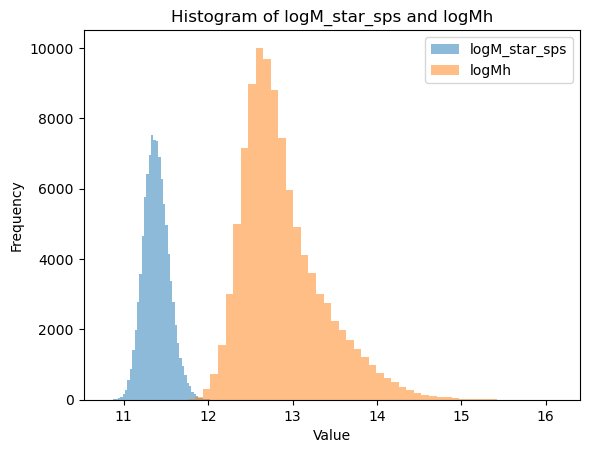

In [13]:
n_samples = 100000
data = generate_samples(n_samples, model='deVauc', random_state=42)

logM_star_sps = data['logM_star_sps']
logMh = data['logMh']


plt.hist(logM_star_sps, bins=50, alpha=0.5, label='logM_star_sps')
plt.hist(logMh, bins=50, alpha=0.5, label='logMh')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of logM_star_sps and logMh')
plt.legend()

Text(0.5, 0, 'Value')

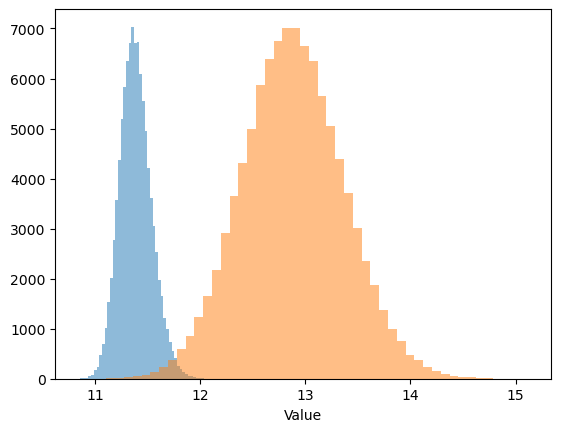

In [11]:
model_name = 'deVauc'
params = MODEL_PARAMS[model_name]
samples = generate_samples(100000, model=model_name)

logM_star_sps = samples['logM_star_sps']
logRe = samples['logRe']
logMh = samples['logMh']

plt.hist(logM_star_sps, bins=50, alpha=0.5, label='logM_star_sps')
# plt.hist(logRe, bins=50, alpha=0.5, label='logRe')
plt.hist(logMh, bins=50, alpha=0.5, label='logMh')
plt.xlabel('Value')

Text(0, 0.5, 'Frequency')

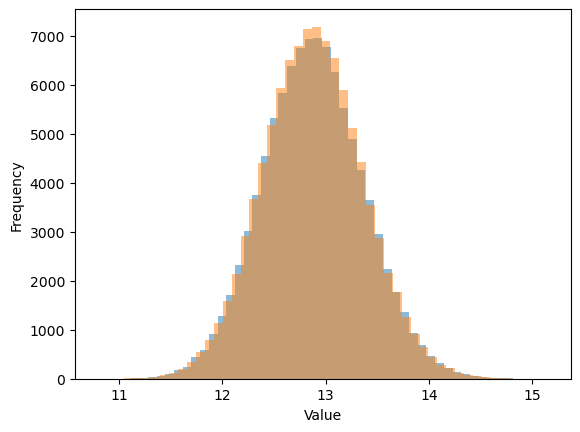

In [2]:
from mass_sampler import generate_samples, MODEL_PARAMS
import matplotlib.pyplot as plt
n_samples = 100000
data1 = generate_samples(n_samples, model='deVauc', random_state=42)
logMh1 = data1['logMh']

data2 = generate_samples(n_samples, model='deVauc', random_state=None)
logMh2 = data2['logMh']

plt.hist(logMh1, bins=50, alpha=0.5, label='logMh1')
plt.hist(logMh2, bins=50, alpha=0.5, label='logMh2')
plt.xlabel('Value')
plt.ylabel('Frequency')

In [18]:
from scipy.stats import ks_2samp
statistic, pvalue = ks_2samp(logMh1, logMh2)
print(f"KS statistic = {statistic:.5e}, p = {pvalue:.3g}")


KS statistic = 9.43216e-02, p = 0


你的 `generate_samples` 中虽然只传入了一个 `random_state` 参数，但它会**多次传递给三个不同的 `rvs(...)` 调用**（即三个子采样器），这会导致：

---

### ✅ 当前代码的结构

```python
rvs(size=n, random_state=random_state)
```

在三个地方依次使用：

* 生成 `logM_star_sps`
* 然后用它生成 `logRe`
* 再用两者生成 `logMh`

---

### 🚨 原因：传递相同 seed 到多个采样器 = 每次采样都从同一状态开始

`scipy.stats` 中的 `rvs(..., random_state=...)` 是**可重入的**，即：

> 每次你调用 `rvs(..., random_state=42)`，它**从头重新启动该 seed 所决定的随机序列**！

---

### 🔁 具体后果是：

你写的代码就像在执行：

```python
rng = np.random.default_rng(42)

logM_star_sps = skewnorm(...).rvs(..., random_state=rng)
logRe = norm(...).rvs(..., random_state=rng)      # 重复使用 rng
logMh = norm(...).rvs(..., random_state=rng)      # 重复使用 rng
```

**但实际上你是这样做的：**

```python
logM_star_sps = skewnorm(...).rvs(..., random_state=42)
logRe = norm(...).rvs(..., random_state=42)
logMh = norm(...).rvs(..., random_state=42)
```

即**每次都重新创建一个随机状态，生成结果总是相同**，就像把骰子永远停在第一次一样。

---

### ✅ 正确写法：共享一个 RNG 对象

你可以改写为：

```python
def generate_samples(n_samples, model='deVauc', random_state=None):
    rng = np.random.default_rng(random_state)

    logM_star_sps = mstar_gene(n_samples, model=model, random_state=rng)
    logRe = logRe_given_logM(logM_star_sps, model=model, random_state=rng)
    logMh = logMh_given_logM_logRe(logM_star_sps, logRe, model=model, random_state=rng)
```

然后三个采样函数也都接受 `Generator` 类型的 `random_state`，例如：

```python
def mstar_gene(n, model='deVauc', random_state=None):
    ...
    return dist.rvs(size=n, random_state=random_state)  # 支持 Generator 实例
```

---

### ✅ 总结

| 问题点           | 影响                  |
| ------------- | ------------------- |
| 多次传入相同整数 seed | 每次采样结果都一样（不是独立）     |
| 导致所有链式变量都高度相关 | 导致 `logMh` 的分布收缩、偏斜 |
| KS 检验明显区分     | 实际上采样“退化”了          |

---

是否需要我帮你一键改写整个模块，使它支持统一的 `np.random.Generator`？这能从根本解决问题，并保持科学性与重现性。
